In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import pickle
from feature_extraction.pretrained_models_xrv import load_torchxrayvision_model, extract_features_from_folder

ModuleNotFoundError: No module named 'feature_extraction'

In [31]:
# Define dataset directory
dataset_dir = "data/pneumonia/all_unique"

In [32]:
# Loading extracted features
all_features = np.load("data/representations/pneumonia/densenet121-res224-all/latent_features.npy")
labels = np.load("data/representations/pneumonia/densenet121-res224-all/labels.npy")

In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import statsmodels.api as sm
from scipy.stats import norm

# ========================
# 1. Define the XRayDataset
# ========================
class XRayDataset(Dataset):
    """
    Dataset for loading chest X-ray images from a folder structure with
    subfolders 'NORMAL' and 'PNEUMONIA'.
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []  # Each element is (file_path, label, filename)
        self.categories = ['NORMAL', 'PNEUMONIA']
        self.transform = transform
        
        print(f"Loading images from: {root_dir}")
        for cat in self.categories:
            cat_dir = os.path.join(root_dir, cat)
            if not os.path.isdir(cat_dir):
                print(f"Warning: Category folder '{cat_dir}' not found.")
                continue
            print(f"Scanning category: {cat}")
            for fname in os.listdir(cat_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(cat_dir, fname)
                    self.samples.append((file_path, cat, fname))
                else:
                    print(f"Skipping non-image file: {fname}")
        print(f"Found {len(self.samples)} samples in '{root_dir}'.")
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label, fname = self.samples[idx]
        # Open the image and convert to grayscale (1 channel)
        image = Image.open(file_path).convert("L")
        if self.transform:
            image = self.transform(image)
        # Return image tensor, label string, and original filename
        return image, label, fname

# ========================
# 2. Define transforms and load dataset
# ========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # scales pixels to [0,1]
])

input_folder = "data/pneumonia/all_unique"  # Original images
dataset = XRayDataset(input_folder, transform=transform)

# Convert dataset to a NumPy array (all images) and collect labels
X_list = []
labels_list = []
for i in range(len(dataset)):
    image, label, fname = dataset[i]
    X_list.append(image.numpy())  # convert torch.Tensor to numpy array
    labels_list.append(label)
X_images = np.stack(X_list, axis=0)  # shape: (n_samples, channels, height, width)

# Map labels to numeric: e.g. NORMAL -> 0, PNEUMONIA -> 1
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}
pneumonia_label = np.array([label_mapping[lbl] for lbl in labels_list])

# ========================
# 3. Simulation and Estimation Parameters
# ========================
beta_true = 2.0     # True effect of treatment A on outcome Y
gamma_true = -1     # Effect of pneumonia on Y
p_treat_given_pneu = 0.7    # Probability of treatment if pneumonia
p_treat_given_normal = 0.3  # Probability of treatment if normal
n_samples = pneumonia_label.shape[0]

# For confidence intervals
n_runs = 200   # Number of simulation runs; adjust as needed
ci_alpha_level = 0.05
z_score = norm.ppf(1 - ci_alpha_level / 2)

# ========================
# 4. Define Dummy CNN Nuisance Models (replace with your actual CNN wrappers)
# ========================
class DummyCNNForOutcome:
    """A dummy CNN for predicting the outcome Y from images."""
    def fit(self, X, y):
        # In a real implementation, train your CNN (e.g. using PyTorch or Keras)
        self.mean_y = np.mean(y)
    def predict(self, X):
        # Here, simply return the mean of y for every sample
        return np.full((X.shape[0],), self.mean_y)

class DummyCNNForTreatment:
    """A dummy CNN for predicting the treatment A from images."""
    def fit(self, X, y):
        # In a real implementation, train your CNN on images to predict A
        self.mean_d = np.mean(y)
    def predict(self, X):
        return np.full((X.shape[0],), self.mean_d)

# Instantiate the dummy models (or your CNN wrappers)
cnn_for_outcome = DummyCNNForOutcome()
cnn_for_treatment = DummyCNNForTreatment()

# ========================
# 5. Define the DoubleMLPLRImage Class for Image Data
# ========================
from sklearn.model_selection import KFold

class DoubleMLPLRImage:
    """
    Double Machine Learning for Partially Linear Regression with image data.
    
    This version uses only the partialling-out score to estimate the average treatment effect (ATE).
    The nuisance functions (ml_l and ml_m) are assumed to be image-based learners (e.g., CNNs)
    implementing a scikit-learn-like API with fit and predict methods.
    
    Parameters
    ----------
    X : numpy.ndarray
        Array of images (n_samples, channels, height, width).
    y : numpy.ndarray
        Outcome variable (n_samples,).
    d : numpy.ndarray
        Treatment variable (n_samples,).
    ml_l : estimator
        Nuisance learner for predicting y from images.
    ml_m : estimator
        Nuisance learner for predicting d from images.
    n_folds : int, default=2
        Number of folds for cross-fitting.
    n_rep : int, default=1
        Number of repetitions for sample splitting.
    """
    def __init__(self, X, y, d, ml_l, ml_m, n_folds=2, n_rep=1):
        self.X = X
        self.y = y
        self.d = d
        self.ml_l = ml_l
        self.ml_m = ml_m
        self.n_folds = n_folds
        self.n_rep = n_rep
        self.coef = None  # To store the estimated ATE
        self.se = None    # To store the standard error

    def fit(self):
        rep_coef = []
        n = self.X.shape[0]
        
        # Repeat the procedure n_rep times with different splits
        for rep in range(self.n_rep):
            kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=rep)
            # Initialize arrays to hold residuals
            u_all = np.empty(n, dtype=float)  # outcome residuals
            v_all = np.empty(n, dtype=float)  # treatment residuals
            
            for train_idx, test_idx in kf.split(self.X):
                X_train, X_test = self.X[train_idx], self.X[test_idx]
                y_train, y_test = self.y[train_idx], self.y[test_idx]
                d_train, d_test = self.d[train_idx], self.d[test_idx]
                
                # Fit and predict with the outcome model (ml_l)
                self.ml_l.fit(X_train, y_train)
                y_pred = self.ml_l.predict(X_test)
                
                # Fit and predict with the treatment model (ml_m)
                self.ml_m.fit(X_train, d_train)
                d_pred = self.ml_m.predict(X_test)
                
                # Compute residuals
                u_all[test_idx] = y_test - y_pred
                v_all[test_idx] = d_test - d_pred
            
            # Estimate ATE for this repetition using partialling-out formula:
            theta_rep = np.sum(v_all * u_all) / np.sum(v_all**2)
            rep_coef.append(theta_rep)
        
        # Average ATE estimates over repetitions
        self.coef = np.mean(rep_coef)
        if self.n_rep > 1:
            self.se = np.std(rep_coef, ddof=1) / np.sqrt(self.n_rep)
        else:
            self.se = np.nan  # or you may choose not to compute SE for a single repetition
        return self

Loading images from: data/pneumonia/all_unique
Scanning category: NORMAL
Skipping non-image file: .DS_Store
Scanning category: PNEUMONIA
Skipping non-image file: .DS_Store
Found 3769 samples in 'data/pneumonia/all_unique'.


In [4]:
# ========================
# 6. Simulation Loop: Naive, Oracle, and DML (using CNNs on images)
# ========================
methods = ['Naive', 'Oracle', 'DML (CNN)']
estimates_dict = {method: [] for method in methods}
cis_dict = {method: {'se': [], 'lower': [], 'upper': []} for method in methods}

n_runs = 2  # Number of simulation runs
seed = 42
for run in range(n_runs):
    print(f"\n--- Simulation Run {run + 1} ---")
    seed += 2  # update seed for variability
    np.random.seed(seed)
    
    # 6.1 Simulate treatment A based on pneumonia status
    pA = pneumonia_label * p_treat_given_pneu + (1 - pneumonia_label) * p_treat_given_normal
    A = np.random.binomial(1, pA)
    
    # 6.2 Simulate outcome Y
    noise = np.random.normal(loc=0, scale=1, size=n_samples)
    Y = beta_true * A + gamma_true * pneumonia_label + noise
    
    # 6.3 Package data into a DataFrame (for naive and oracle OLS)
    df = pd.DataFrame({
        'Y': Y,
        'A': A,
        'pneumonia': pneumonia_label
    })
    
    # Naive OLS: regress Y on A only
    X_naive = sm.add_constant(df['A'])
    model_naive = sm.OLS(df['Y'], X_naive).fit()
    beta_naive = model_naive.params['A']
    se_naive = model_naive.bse['A']
    ci_lower_naive = beta_naive - z_score * se_naive
    ci_upper_naive = beta_naive + z_score * se_naive
    estimates_dict['Naive'].append(beta_naive)
    cis_dict['Naive']['se'].append(se_naive)
    cis_dict['Naive']['lower'].append(ci_lower_naive)
    cis_dict['Naive']['upper'].append(ci_upper_naive)
    print(f"Naive OLS: β = {beta_naive:.3f}, SE = {se_naive:.3f}")
    
    # Oracle OLS: regress Y on A and pneumonia (i.e. adjusting for the confounder)
    X_oracle = sm.add_constant(df[['A', 'pneumonia']])
    model_oracle = sm.OLS(df['Y'], X_oracle).fit()
    beta_oracle = model_oracle.params['A']
    se_oracle = model_oracle.bse['A']
    ci_lower_oracle = beta_oracle - z_score * se_oracle
    ci_upper_oracle = beta_oracle + z_score * se_oracle
    estimates_dict['Oracle'].append(beta_oracle)
    cis_dict['Oracle']['se'].append(se_oracle)
    cis_dict['Oracle']['lower'].append(ci_lower_oracle)
    cis_dict['Oracle']['upper'].append(ci_upper_oracle)
    print(f"Oracle OLS: β = {beta_oracle:.3f}, SE = {se_oracle:.3f}")
    
    # DML using image data and CNN nuisance functions:
    # Here we use the full image array X_images (loaded above), along with Y and A
    dml_plr_image = DoubleMLPLRImage(X_images, Y, A,
                                     ml_l=cnn_for_outcome,
                                     ml_m=cnn_for_treatment,
                                     n_folds=2,
                                     n_rep=1)
    dml_plr_image.fit()
    beta_dml_cnn = dml_plr_image.coef
    se_dml_cnn = dml_plr_image.se
    estimates_dict['DML (CNN)'].append(beta_dml_cnn)
    ci_lower_dml_cnn = beta_dml_cnn - z_score * se_dml_cnn
    ci_upper_dml_cnn = beta_dml_cnn + z_score * se_dml_cnn
    cis_dict['DML (CNN)']['se'].append(se_dml_cnn)
    cis_dict['DML (CNN)']['lower'].append(ci_lower_dml_cnn)
    cis_dict['DML (CNN)']['upper'].append(ci_upper_dml_cnn)
    print(f"DML (CNN): β = {beta_dml_cnn:.3f}, SE = {se_dml_cnn:.3f}")



--- Simulation Run 1 ---
Naive OLS: β = 1.720, SE = 0.036
Oracle OLS: β = 2.062, SE = 0.035
DML (CNN): β = 1.720, SE = nan

--- Simulation Run 2 ---
Naive OLS: β = 1.650, SE = 0.036
Oracle OLS: β = 1.991, SE = 0.036
DML (CNN): β = 1.649, SE = nan

--- Simulation Run 3 ---
Naive OLS: β = 1.625, SE = 0.035
Oracle OLS: β = 1.979, SE = 0.035
DML (CNN): β = 1.625, SE = nan

--- Simulation Run 4 ---
Naive OLS: β = 1.669, SE = 0.035
Oracle OLS: β = 2.020, SE = 0.035
DML (CNN): β = 1.669, SE = nan

--- Simulation Run 5 ---
Naive OLS: β = 1.675, SE = 0.036
Oracle OLS: β = 2.016, SE = 0.035
DML (CNN): β = 1.677, SE = nan

--- Simulation Run 6 ---
Naive OLS: β = 1.598, SE = 0.036
Oracle OLS: β = 1.939, SE = 0.036
DML (CNN): β = 1.596, SE = nan

--- Simulation Run 7 ---
Naive OLS: β = 1.678, SE = 0.036
Oracle OLS: β = 2.013, SE = 0.036
DML (CNN): β = 1.678, SE = nan

--- Simulation Run 8 ---
Naive OLS: β = 1.623, SE = 0.035
Oracle OLS: β = 1.989, SE = 0.035
DML (CNN): β = 1.619, SE = nan

--- Sim

### Alternative Implementation

In [33]:
# Define dataset directory
dataset_dir = "data/pneumonia/all_unique"

# Loading extracted features
all_features = np.load("data/representations/pneumonia/densenet121-res224-all/latent_features.npy")
labels = np.load("data/representations/pneumonia/densenet121-res224-all/labels.npy")

In [34]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import statsmodels.api as sm
from scipy.stats import norm
# Define the XRayDataset
class XRayDataset(Dataset):
    """
    Dataset for loading chest X-ray images from a folder structure with
    subfolders 'NORMAL' and 'PNEUMONIA'.
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []  # Each element is (file_path, label, filename)
        self.categories = ['NORMAL', 'PNEUMONIA']
        self.transform = transform
        
        print(f"Loading images from: {root_dir}")
        for cat in self.categories:
            cat_dir = os.path.join(root_dir, cat)
            if not os.path.isdir(cat_dir):
                print(f"Warning: Category folder '{cat_dir}' not found.")
                continue
            print(f"Scanning category: {cat}")
            for fname in os.listdir(cat_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(cat_dir, fname)
                    self.samples.append((file_path, cat, fname))
                else:
                    print(f"Skipping non-image file: {fname}")
        print(f"Found {len(self.samples)} samples in '{root_dir}'.")
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label, fname = self.samples[idx]
        # Open the image and convert to grayscale (1 channel)
        image = Image.open(file_path).convert("L")
        if self.transform:
            image = self.transform(image)
        # Return image tensor, label string, and original filename
        return image, label, fname


In [35]:
import numpy as np
from sklearn.model_selection import KFold

class DoubleMLPLRImage:
    """
    Double Machine Learning for Partially Linear Regression with image data.
    
    This simplified version only uses the partialling-out score for the ATE,
    and it assumes that the nuisance learners (ml_l for outcome and ml_m for treatment)
    are CNNs (or any image-based learner) implementing a scikit-learn-like API (fit/predict).
    
    Parameters
    ----------
    X : numpy.ndarray
        Array of images (shape: n_samples x ...). Typically, this might be 
        (n_samples, channels, height, width) or (n_samples, height, width, channels).
    
    y : numpy.ndarray
        Outcome variable (n_samples, ).
    
    d : numpy.ndarray
        Treatment variable (n_samples, ). Can be continuous or binary.
    
    ml_l : estimator
        Nuisance function to predict y from X (e.g. a CNN regressor).
    
    ml_m : estimator
        Nuisance function to predict d from X (e.g. a CNN regressor or classifier).
    
    n_folds : int, default=2
        Number of folds for cross-fitting.
    
    n_rep : int, default=1
        Number of repetitions of the sample-splitting.
    """
    
    def __init__(self, X, y, d, ml_l, ml_m, n_folds=2, n_rep=1):
        self.X = X
        self.y = y
        self.d = d
        self.ml_l = ml_l
        self.ml_m = ml_m
        self.n_folds = n_folds
        self.n_rep = n_rep
        self.coefs = None  # to store coefficient estimates (one per rep)
        self.se = None     # to store estimated standard error

    def fit(self):
        rep_coef = []
        n = self.X.shape[0]
        
        # Repeat the procedure n_rep times with different splits
        for rep in range(self.n_rep):
            # Create folds (shuffle with a different seed each repetition)
            kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=rep)
            # placeholders for residuals (u: outcome residual, v: treatment residual)
            u_all = np.empty(n, dtype=float)
            v_all = np.empty(n, dtype=float)
            
            for train_idx, test_idx in kf.split(self.X):
                X_train, X_test = self.X[train_idx], self.X[test_idx]
                y_train, y_test = self.y[train_idx], self.y[test_idx]
                d_train, d_test = self.d[train_idx], self.d[test_idx]
                
                # Fit outcome model (ml_l) on training data and predict on test
                self.ml_l.fit(X_train, y_train)
                y_pred = self.ml_l.predict(X_test)
                
                # Fit treatment model (ml_m) on training data and predict on test
                self.ml_m.fit(X_train, d_train)
                d_pred = self.ml_m.predict(X_test)
                
                # Compute residuals: u = y - predicted y, v = d - predicted d
                u_all[test_idx] = y_test - y_pred
                v_all[test_idx] = d_test - d_pred

            # Compute the ATE estimate for this repetition: theta = sum(v * u) / sum(v^2)
            # theta_rep = np.sum(v_all * u_all) / np.sum(v_all**2)
            orth_lm = sm.OLS(u_all, v_all).fit(cov_type='HC0')
            theta_rep = orth_lm.params
            rep_coef.append(theta_rep)
        
        # Average across repetitions
        self.coef = np.mean(rep_coef)
        if self.n_rep > 1:
            self.se = np.std(rep_coef, ddof=1) / np.sqrt(self.n_rep)
        else:
            self.se = orth_lm.HC0_se[0]
        return self


In [36]:
import os
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.utils import shuffle
from scipy.stats import norm

# Define transforms: resize to 224x224 and convert to tensor (scales pixels to [0,1])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create the dataset and DataLoader
input_folder = "data/pneumonia/all_unique"
dataset = XRayDataset(input_folder, transform=transform)

batch_size = all_features.shape[0]  # Use all samples avialbale and subsample later
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

Loading images from: data/pneumonia/all_unique
Scanning category: NORMAL
Skipping non-image file: .DS_Store
Scanning category: PNEUMONIA
Skipping non-image file: .DS_Store
Found 3769 samples in 'data/pneumonia/all_unique'.


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

class CNNRegressor(BaseEstimator, RegressorMixin):
    """
    Wrapper for a PyTorch CNN model to make it compatible with scikit-learn's fit/predict interface.
    """
    def __init__(self, model, epochs=5, batch_size=32, learning_rate=0.001, is_classifier=False):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.is_classifier = is_classifier
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def fit(self, X, y):
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.BCEWithLogitsLoss() if self.is_classifier else nn.MSELoss()

        # Convert data to tensors
        X_tensor = torch.from_numpy(X).float().to(self.device)
        y_tensor = torch.from_numpy(y).float().view(-1, 1).to(self.device)
        
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        for epoch in range(self.epochs):
            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.from_numpy(X).float().to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor).cpu().numpy()
        
        # Ensure correct shape and apply classification threshold if needed
        outputs = outputs.reshape(-1)  # Flatten to (batch_size,)
        
        if self.is_classifier:
            return (outputs > 0.5).astype(int)  # Convert logits to binary predictions (0/1)
    
        return outputs


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple CNN model for outcome and treatment prediction
class SimpleCNN(nn.Module):
    def __init__(self, output_dim=1, is_classifier=False):
        super(SimpleCNN, self).__init__()
        self.is_classifier = is_classifier
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),  # Assuming input images are 224x224
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        x = x.view(-1, 1)  # Output shape is (batch_size, 1)
        if self.is_classifier:
            x = torch.sigmoid(x)  # Apply sigmoid for binary classification
        return x

# Initialize raw PyTorch CNN models
cnn_for_outcome = SimpleCNN(output_dim=1, is_classifier=False)  # For continuous outcome
cnn_for_treatment = SimpleCNN(output_dim=1, is_classifier=True)  # For binary treatment

# Wrap models using the CNNRegressor class
cnn_for_outcome = CNNRegressor(cnn_for_outcome, epochs=10, is_classifier=False)
cnn_for_treatment = CNNRegressor(cnn_for_treatment, epochs=10, is_classifier=True)



In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

class EnhancedCNN(nn.Module):
    def __init__(self, output_dim=1, is_classifier=False):
        super(EnhancedCNN, self).__init__()
        self.is_classifier = is_classifier
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7)),  # Ensuring output feature map size is (7,7)
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        x = x.view(-1, 1)
        if self.is_classifier:
            x = torch.sigmoid(x)
        return x
    
# Initialize raw PyTorch CNN models
cnn_for_outcome = EnhancedCNN(output_dim=1, is_classifier=False)  # For continuous outcome
cnn_for_treatment = EnhancedCNN(output_dim=1, is_classifier=True)  # For binary treatment

# Wrap models using the CNNRegressor class
cnn_for_outcome = CNNRegressor(cnn_for_outcome, epochs=10, is_classifier=False)
cnn_for_treatment = CNNRegressor(cnn_for_treatment, epochs=10, is_classifier=True)

In [49]:
from doubleml import DoubleMLData, DoubleMLPLR
from torch.utils.data import DataLoader

# Set up training loop parameters
n_runs = 5  
n_samples_run = 500  # Number of samples to use in each run
# n_samples_run = all_features.shape[0]  # Use all samples available
ci_alpha_level = 0.05  # Confidence interval alpha level
z_score = norm.ppf(1 - ci_alpha_level / 2)  # Z-score for 1-alpha confidence intervals

# Initialize storage for estimates and confidence intervals
methods = ['Naive', 'Oracle', 'DML (Pre-trained)', 'DML (CNN)']
estimates_dict = {method: [] for method in methods}
cis_dict = {method: {'se': [], 'lower': [], 'upper': []} for method in methods}

# Set seed for reproducibility
seed = 42

for run in range(n_runs):
    print(f"\n--- Simulation Run {run + 1} ---")
    seed = seed + 2  # Ensure different seed for each run
    np.random.seed(seed)

    # 1. Load image data (unshuffled)
    images, labels, filenames = next(iter(dataloader))
    label_mapping = {"NORMAL": 0, "PNEUMONIA": 1}
    labels = np.array([label_mapping[label] for label in labels])
    labels = labels.astype(int)  # Ensure binary (0/1) labels for pneumonia
    n_samples_total = len(labels)
    
    # 2. Load pretrained representations (in the same unshuffled order)
    all_features_pretrained = np.load("data/representations/pneumonia/densenet121-res224-all/latent_features.npy")
    features_pretrained = all_features_pretrained[:n_samples_total]
    all_labels_pretrained = np.load("data/representations/pneumonia/densenet121-res224-all/labels.npy")
    labels_pretrained = all_labels_pretrained[:n_samples_total]
    
    # Ensure the labels match between the images and the representations
    assert np.array_equal(labels, labels_pretrained), "Labels do not match between dataset and representations."
    
    # 3. Generate random indices for shuffling
    random_indices = np.random.permutation(n_samples_total)
    
    # 4. Shuffle both images and representations using the same indices
    images = images[random_indices][:n_samples_run]
    labels = labels[random_indices][:n_samples_run]
    features_pretrained = features_pretrained[random_indices][:n_samples_run]
    labels_pretrained = labels_pretrained[random_indices][:n_samples_run]
    
    # Sanity check to ensure labels are still matching
    assert np.array_equal(labels, labels_pretrained), "Labels do not match after shuffling."
    print(f"Sampled {n_samples_run} observations of {n_samples_total} for this run.")

    # Simulate Treatment A
    p_treat_given_pneu = 0.7
    p_treat_given_normal = 0.3
    pA = labels * p_treat_given_pneu + (1 - labels) * p_treat_given_normal
    A = np.random.binomial(1, pA)

    # Simulate Outcome Y
    beta_true = 2.0
    gamma_true = -2.0
    noise = np.random.normal(loc=0, scale=1, size=n_samples_run)
    Y = beta_true * A + gamma_true * labels + noise

    # Prepare DataFrame for DoubleML
    df = pd.DataFrame({'Y': Y, 'A': A, 'pneumonia': labels})

    ## Naive OLS (Unadjusted)
    X_naive = sm.add_constant(df['A']) 
    model_naive = sm.OLS(df['Y'], X_naive).fit()
    beta_naive = model_naive.params['A']
    se_naive = model_naive.bse['A']
    ci_lower_naive = beta_naive - z_score * se_naive
    ci_upper_naive = beta_naive + z_score * se_naive
    estimates_dict['Naive'].append(beta_naive)
    cis_dict['Naive']['lower'].append(ci_lower_naive)
    cis_dict['Naive']['upper'].append(ci_upper_naive)
    print(f"Naive OLS: β = {beta_naive:.3f}, SE = {se_naive:.3f}")
    
    ## Oracle OLS (Adjusting for pneumonia)
    X_oracle = sm.add_constant(df[['A', 'pneumonia']])
    model_oracle = sm.OLS(df['Y'], X_oracle).fit()
    beta_oracle = model_oracle.params['A']
    se_oracle = model_oracle.bse['A']
    ci_lower_oracle = beta_oracle - z_score * se_oracle
    ci_upper_oracle = beta_oracle + z_score * se_oracle
    estimates_dict['Oracle'].append(beta_oracle)
    cis_dict['Oracle']['lower'].append(ci_lower_oracle)
    cis_dict['Oracle']['upper'].append(ci_upper_oracle)
    print(f"Oracle OLS: β = {beta_oracle:.3f}, SE = {se_oracle:.3f}")

    ## DML with linear models for representations
    # Convert pre-trained features to DataFrame
    X_dml_df = pd.DataFrame(
        features_pretrained,
        columns=[f"feat_{i}" for i in range(features_pretrained.shape[1])]
    )

    # Add outcome and treatment to DoubleMLData via column names
    X_dml_df['Y'] = df['Y'].copy()
    X_dml_df['A'] = df['A'].copy()

    # Create DoubleMLData
    data_dml = DoubleMLData(X_dml_df, "Y", "A")

    # DoubleML with Linear Models Estimators
    try:
        # Define nuisance models with linear models
        ml_g_linear = LinearRegression() # Outcome model
        ml_m_linear = LogisticRegression()  # Treatment model

    
        # Instantiate and fit DoubleMLPLR
        dml_plr_linear = DoubleMLPLR(data_dml, ml_g_linear, ml_m_linear, n_folds=2) 
        dml_plr_linear.fit()
        beta_dml_linear = dml_plr_linear.coef[0]
        se_dml_linear = dml_plr_linear.se[0]
        estimates_dict['DML (Pre-trained)'].append(beta_dml_linear)
        # 95% Confidence Interval
        ci_lower_dml_linear = beta_dml_linear - z_score * se_dml_linear
        ci_upper_dml_linear = beta_dml_linear + z_score * se_dml_linear
        cis_dict['DML (Pre-trained)']['lower'].append(ci_lower_dml_linear)
        cis_dict['DML (Pre-trained)']['upper'].append(ci_upper_dml_linear)
        print(f"DML (Pre-trained): β = {beta_dml_linear:.3f}, SE = {se_dml_linear:.3f}")
    except Exception as e:
        print(f"Run {run+1}: DML (Pre-trained) failed with error: {e}")
        estimates_dict['DML (Pre-trained)'].append(np.nan)
        cis_dict['DML (Pre-trained)']['lower'].append(np.nan)
        cis_dict['DML (Pre-trained)']['upper'].append(np.nan)

    ## DML with CNNs for images
    # Initialize DoubleMLPLRImage with CNNs
    dml_plr_image = DoubleMLPLRImage(
        X=images.numpy(), 
        y=Y, 
        d=A, 
        ml_l=cnn_for_outcome, 
        ml_m=cnn_for_treatment,
        n_folds=2, 
        n_rep=1
    )
    
    # Fit the model
    dml_plr_image.fit()

    # Collect results
    beta_dml = dml_plr_image.coef
    se_dml = dml_plr_image.se
    estimates_dict['DML (CNN)'].append(beta_dml)
    ci_lower_dml = beta_dml - z_score * se_dml
    ci_upper_dml = beta_dml + z_score * se_dml
    cis_dict['DML (CNN)']['se'].append(se_dml)
    cis_dict['DML (CNN)']['lower'].append(ci_lower_dml)
    cis_dict['DML (CNN)']['upper'].append(ci_upper_dml)

    print(f"DML (CNN): β = {beta_dml:.3f}, SE = {se_dml:.3f}")


--- Simulation Run 1 ---
Sampled 500 observations of 3769 for this run.
Naive OLS: β = 1.162, SE = 0.114
Oracle OLS: β = 1.914, SE = 0.095
DML (Pre-trained): β = 1.936, SE = 0.202
DML (CNN): β = 0.706, SE = 0.090

--- Simulation Run 2 ---
Sampled 500 observations of 3769 for this run.
Naive OLS: β = 1.466, SE = 0.117
Oracle OLS: β = 2.025, SE = 0.094
DML (Pre-trained): β = 1.876, SE = 0.190
DML (CNN): β = 1.056, SE = 0.085

--- Simulation Run 3 ---
Sampled 500 observations of 3769 for this run.
Naive OLS: β = 1.245, SE = 0.120
Oracle OLS: β = 1.980, SE = 0.099
DML (Pre-trained): β = 2.135, SE = 0.211
DML (CNN): β = 0.734, SE = 0.084

--- Simulation Run 4 ---
Sampled 500 observations of 3769 for this run.
Naive OLS: β = 1.355, SE = 0.117
Oracle OLS: β = 2.039, SE = 0.093
DML (Pre-trained): β = 2.159, SE = 0.186
DML (CNN): β = 0.841, SE = 0.089

--- Simulation Run 5 ---
Sampled 500 observations of 3769 for this run.
Naive OLS: β = 1.308, SE = 0.118
Oracle OLS: β = 1.924, SE = 0.096
DML 

In [27]:
def save_results(run_dir, est_dict, ci_dict):
    os.makedirs(run_dir, exist_ok=True)

    # Save cis_dict
    estimates_path = os.path.join(run_dir, 'estimates_dict.pkl')
    with open(estimates_path, 'wb') as f:
        pickle.dump(est_dict, f)

    # Save cis_dict
    cis_path = os.path.join(run_dir, 'cis_dict.pkl')
    with open(cis_path, 'wb') as f:
        pickle.dump(ci_dict, f)

In [ ]:
# Create a directory for the run and save the results
run_name = "run_all_imdb_labelconf_cnn5_500"
run_dir = os.path.join('results/dml_cnn/', run_name)
save_results(run_dir, estimates_dict, cis_dict)

<Figure size 800x400 with 0 Axes>

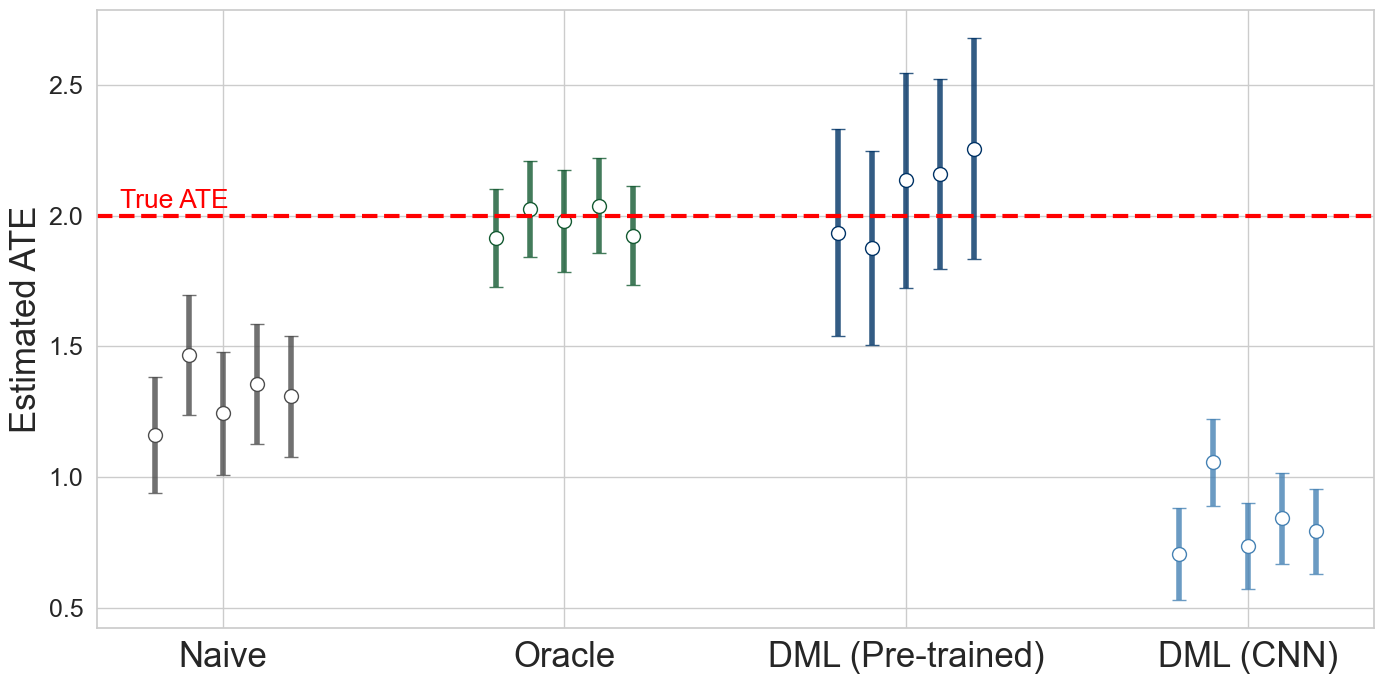

In [51]:
# 6. Aggregate Results
# -------------------------------------------------
# Convert estimates_dict to DataFrame for easier manipulation
estimates_df = pd.DataFrame(estimates_dict)
cis_lower_df = pd.DataFrame({method: cis_dict[method]['lower'] for method in methods})
cis_upper_df = pd.DataFrame({method: cis_dict[method]['upper'] for method in methods})

# 7. Plotting Estimated Coefficients with Confidence Intervals
# -------------------------------------------------
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

# Prepare data for plotting
plot_data = []
for method in methods:
    for run in range(n_runs):
        if not np.isnan(estimates_df.loc[run, method]):
            plot_data.append({
                'Method': method,
                'Run': run + 1,
                'Estimate': estimates_df.loc[run, method],
                'CI Lower': cis_lower_df.loc[run, method],
                'CI Upper': cis_upper_df.loc[run, method]
            })

plot_df = pd.DataFrame(plot_data)

# 3. Assign numerical positions to methods
method_positions = {method: idx for idx, method in enumerate(methods)}

# 4. Define a consistent color palette
palette = sns.color_palette("tab10", n_colors=len(methods))
estimator_colors = dict(zip(methods, palette))

estimator_colors = {
    "Naive": "#4D4D4D", 
    "Oracle": "#145A32", 
    # "S-Learner (Linear)": "#8B0000", 
    # "S-Learner (RF)": "#CC5500",  
    "DML (Pre-trained)": "#003366",  
    "DML (CNN)": "#4682B4",  
}

# 5. Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7), facecolor='white')
ax = plt.gca()

fontsize_plot = 25

# Define offsets for each run to spread the dots
offset_range = 0.2  # Total range for offsets
offsets = np.linspace(-offset_range, offset_range, n_runs)

# Plot each estimate with its confidence interval
for idx, row in plot_df.iterrows():
    method = row['Method']
    run = row['Run']
    x = method_positions[method] + offsets[run - 1]
    estimate = row['Estimate']
    ci_lower = row['CI Lower']
    ci_upper = row['CI Upper']
    color = estimator_colors.get(method, "black") 

    # Plot the confidence interval as a thicker error bar
    ax.errorbar(x, estimate, yerr=[[estimate - ci_lower], [ci_upper - estimate]],fmt='none', ecolor=color, elinewidth=4, capsize=5, alpha=0.8)

    # Plot the estimate as a hollow circle
    ax.plot(x, estimate, marker='o', markerfacecolor='white', markeredgecolor=color, markersize=10, linestyle='')

# 6. Add true ATE line
plt.axhline(y=beta_true, color='red', linestyle='--', linewidth=3, label='True ATE')
plt.text(x=-0.3, y=beta_true + 0.03, s="True ATE", fontsize=19, color='red')

# 7. Customize x-axis
# methods_labels = ["Naive", "Oracle", "S-Learner\n(Linear)", "S-Learner\n(RF)", "DML\n(Linear)", "DML\n(RF)"]
methods_labels = methods
plt.xticks(ticks=list(method_positions.values()), labels=methods_labels, fontsize=fontsize_plot)

plt.yticks(fontsize=18)
plt.ylabel("Estimated ATE", fontsize=fontsize_plot)

# 8. Create a custom legend for the estimators
handles = [plt.Line2D([0], [0], marker='o', color='w', label=method,markerfacecolor='white', markeredgecolor=color, 
                      markersize=8) 
    for method, color in estimator_colors.items()
]

plt.tight_layout()
plot_path = os.path.join(run_dir, 'ate_label_conf_pneu_cnn5_500.pdf')
plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
